In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree

In [2]:
# retrieve code from GitHub
if os.path.exists('miner_py3.py') == True:
    print('miner_py3.py already exists')
else:
    !wget https://raw.githubusercontent.com/MattWallScientist/miner3/master/miner/src/miner_py3.py
        
# add data in a phantom directory ../data, otherwise code won't work, wellcome to hardcoded paths
if os.path.exists('../data') == True:
    print('../data already exists')
else:
    !mkdir ../data
    
## check contents of ../data 
if os.path.exists('../data/identifier_mappings.txt') == True:
    print('../data/identifier_mappings.txt exists')
else:
    !cp ~/projects/cdi/data/miner_resources/miner3-master/miner/data/identifier_mappings.txt ~/github/cdi/data/.

miner_py3.py already exists
../data already exists
../data/identifier_mappings.txt exists


In [3]:
import miner_py3 as miner

# Paths to files

In [4]:
# Path to the miner directory
input_path = '/Users/alomana/projects/cdi/data/miner_resources/'

# create name for results folder where output files will be saved
resultsFolder = "/Users/alomana/scratch/"

# name of the folder containing the miner network
networkFolder = "/Users/alomana/projects/cdi/data/miner_resources/results_minCorrelation_0o2_50_allFiles/"

# load data

In [5]:
# Load expression Data
expressionFile = os.path.join(input_path, "input", "IA12Zscore.csv")
expressionData, conversionTable = miner.preprocess(expressionFile)

completed identifier conversion.
16216 genes were converted.


In [6]:
# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'input','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'input','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'input','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

In [7]:
#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

In [8]:
#Load table for converting gene names
id_table_path = '../data/identifier_mappings.txt'
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

In [9]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [10]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

In [11]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,'input', "survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

In [12]:
# baseline populations
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

Baseline: 779 First relapse: 56 
Any relapse: 102


In [13]:
import importlib
importlib.reload(miner)
subtypes_translocations = [
    "RNASeq_CCND1_Call",
    "RNASeq_WHSC1_Call",
    "RNASeq_MAF_Call",
    "RNASeq_MYC_Call"
]

subtypes_cytogenetics = [
    "del17",
    "amp1q"
]

patients_by_subtype = []
for subtype in subtypes_cytogenetics:
    subtype_patients = miner.getMutations(subtype,cytogenetics)
    subtype_patients = [name for name in guanSurvivalDfMMRF.index if name in subtype_patients]
    subtype_patients.reverse()
    patients_by_subtype.append(subtype_patients)

for subtype in subtypes_translocations:
    subtype_patients = miner.getMutations(subtype,translocations)
    subtype_patients = [name for name in guanSurvivalDfMMRF.index if name in subtype_patients]
    subtype_patients.reverse()
    patients_by_subtype.append(subtype_patients)
    
remainder = [name for name in guanSurvivalDfMMRF.index if name not in np.hstack(patients_by_subtype)]
remainder.reverse()

sorted_by_subtype = np.hstack([remainder,np.hstack(patients_by_subtype),relapse_patients])
print(sorted_by_subtype.shape)

(954,)


In [14]:
network_activity_diff = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=diff_matrix_MMRF.copy(),
                                                 minRegulons = 2)

In [15]:
# define genes of interest
ccnd1 = "ENSG00000110092"
noxa = "ENSG00000141682"
bak = "ENSG00000030110"

In [24]:
# Generate dataframe with genes related to venetoclax
network_activity = network_activity_diff.copy()
noxa_over_bak = {'CCND1':np.array(network_activity.loc[ccnd1,:]),
                 'NOXA':np.array(network_activity.loc[noxa,:]),
                 'BAK':np.array(network_activity.loc[bak,:]),
                 'NOXA/BAK':np.array(network_activity.loc[noxa,:])-np.array(network_activity.loc[bak,:]),                 
                }
print(type(noxa_over_bak))
noxa_over_bak = pd.DataFrame(noxa_over_bak)

print('index', noxa_over_bak.index)
print('columns', network_activity.columns)

noxa_over_bak.index = network_activity.columns


# Organize data by subtypes
venetoclax_markers = noxa_over_bak.loc[np.hstack(sorted_by_subtype),:]
venetoclax_markers = venetoclax_markers.T

#print(len(sorted_by_subtype), sorted_by_subtype[:10])

<class 'dict'>
index RangeIndex(start=0, stop=881, step=1)
columns Index(['MMRF_1270_1_BM', 'MMRF_1037_1_BM', 'MMRF_2644_1_BM', 'MMRF_1235_1_BM',
       'MMRF_1621_1_BM', 'MMRF_2313_1_BM', 'MMRF_1936_1_BM', 'MMRF_2006_1_BM',
       'MMRF_2720_1_BM', 'MMRF_1654_1_BM',
       ...
       'MMRF_2001_1_BM', 'MMRF_1295_1_BM', 'MMRF_2721_1_BM', 'MMRF_1296_1_BM',
       'MMRF_2125_1_BM', 'MMRF_1374_1_BM', 'MMRF_2525_1_BM', 'MMRF_1307_1_BM',
       'MMRF_1807_1_BM', 'MMRF_2082_1_BM'],
      dtype='object', length=881)


In [17]:
importlib.reload(miner)
# Generate boxplot data
boxplot_data_noxa = [noxa_over_bak.loc[subtype,'NOXA'] for subtype in patients_by_subtype]
boxplot_data_bak = [noxa_over_bak.loc[subtype,'BAK'] for subtype in patients_by_subtype]
boxplot_data_nb = [noxa_over_bak.loc[subtype,'NOXA/BAK'] for subtype in patients_by_subtype]

# Define labels for subtypes in boxplot data
labels = ["Del 17","Amp 1q","t(11;14)","t(4;14)","t(14;16)","MYC"]

# Format boxplot data for plotting
formatted_boxplot_data_noxa = miner.boxplot_figure(boxplot_data_noxa,labels)
formatted_boxplot_data_bak = miner.boxplot_figure(boxplot_data_bak,labels)
formatted_boxplot_data_nb = miner.boxplot_figure(boxplot_data_nb,labels)

print(patients_by_subtype, len(patients_by_subtype))

[['MMRF_1030_1_BM', 'MMRF_1086_1_BM', 'MMRF_1665_1_BM', 'MMRF_1621_1_BM', 'MMRF_1839_1_BM', 'MMRF_2215_1_BM', 'MMRF_2238_1_BM', 'MMRF_2097_1_BM', 'MMRF_2271_1_BM', 'MMRF_2220_1_BM', 'MMRF_2250_1_BM', 'MMRF_2449_1_BM', 'MMRF_2170_1_BM', 'MMRF_2568_1_BM', 'MMRF_2579_1_BM', 'MMRF_2570_1_BM', 'MMRF_2611_1_BM', 'MMRF_1212_1_BM', 'MMRF_1715_1_BM', 'MMRF_1584_1_BM', 'MMRF_1032_1_BM', 'MMRF_1257_1_BM', 'MMRF_1513_1_BM', 'MMRF_2083_1_BM', 'MMRF_1637_1_BM', 'MMRF_1797_1_BM', 'MMRF_1613_1_BM', 'MMRF_1595_1_BM', 'MMRF_1501_1_BM', 'MMRF_1374_1_BM', 'MMRF_1148_1_BM', 'MMRF_1668_1_BM', 'MMRF_2557_1_BM', 'MMRF_2272_1_BM', 'MMRF_1450_1_BM'], ['MMRF_1290_1_BM', 'MMRF_1355_1_BM', 'MMRF_1323_1_BM', 'MMRF_1344_1_BM', 'MMRF_1423_1_BM', 'MMRF_1478_1_BM', 'MMRF_1494_1_BM', 'MMRF_1520_1_BM', 'MMRF_1523_1_BM', 'MMRF_1447_1_BM', 'MMRF_1510_1_BM', 'MMRF_1640_1_BM', 'MMRF_1630_1_BM', 'MMRF_1593_1_BM', 'MMRF_1664_1_BM', 'MMRF_1603_1_BM', 'MMRF_1652_1_BM', 'MMRF_1758_1_BM', 'MMRF_1722_1_BM', 'MMRF_1683_1_BM', 'MMRF_

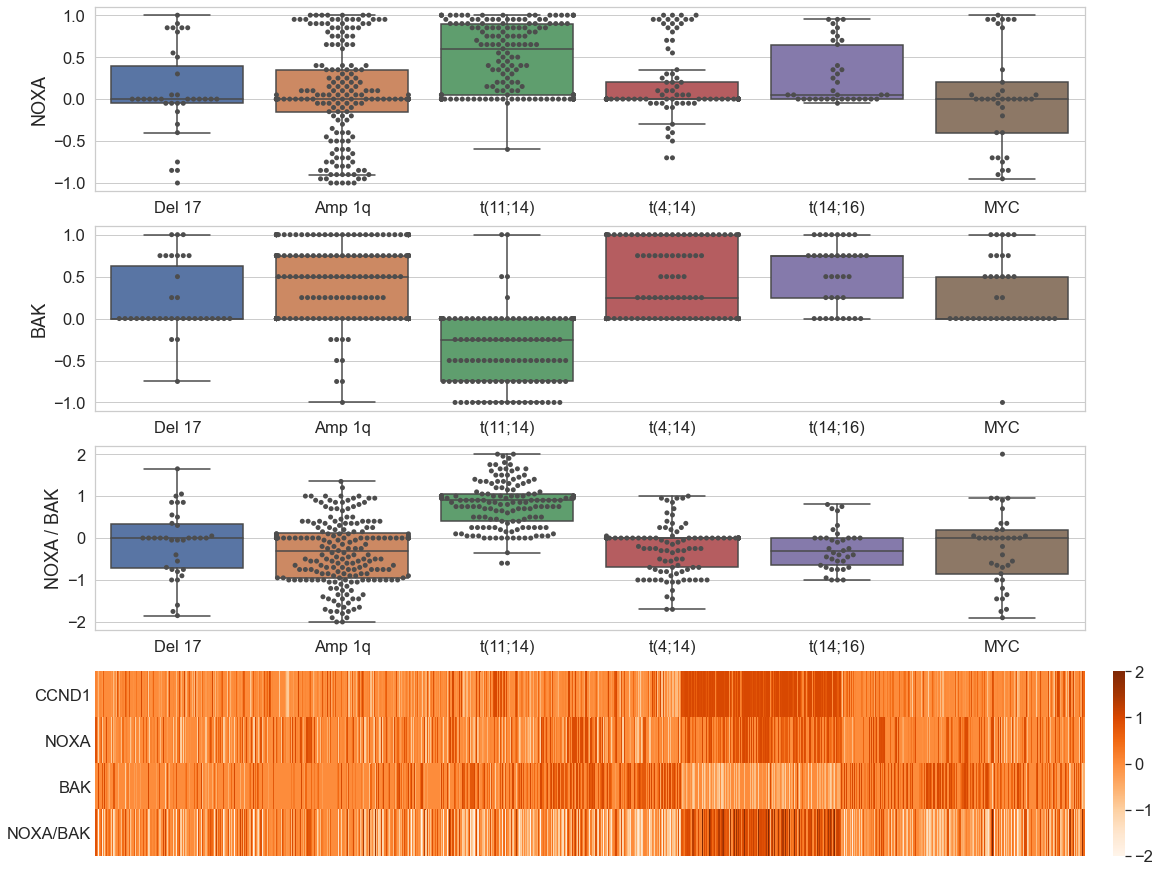

In [18]:
boxplots = [formatted_boxplot_data_noxa,
            formatted_boxplot_data_bak,
            formatted_boxplot_data_nb
           ]

boxplots_labels = ["NOXA","BAK","NOXA / BAK"]

# Set plot style
sns.set(font_scale=1.5,style="whitegrid")
# Instantiate figure
fig = plt.figure(constrained_layout=True,figsize=(16,12))

# Set figure axes
num_plots = 4
gs = fig.add_gridspec(num_plots, 1)

for b in range(num_plots-1):
    # Fill first subplot
    fig.add_subplot(gs[b,0])
    # Plot the orbital period with horizontal boxes
    sns.boxplot(x="label", y="data", data=boxplots[b],fliersize=0)
    # Add in points to show each observation
    sns.swarmplot(x="label", y="data", data=boxplots[b],
                  size=5, color=".3", linewidth=0)
    plt.ylabel(boxplots_labels[b])
    plt.xlabel("")

ax = fig.add_subplot(gs[num_plots-1, 0])
sns.heatmap(venetoclax_markers,cmap = "Oranges",square=False)
ax.set_yticklabels(labels = venetoclax_markers.index,rotation=0)
ax.set_xticklabels(labels="",FontSize=0)
ax.tick_params(axis='both', which='both', length=0)

plt.savefig(os.path.join(resultsFolder,"t(11;14)_BCL2_genes_figure.pdf"),bbox_inches="tight")

# clean local data

In [19]:
#!rm -rf ../data
#!rm miner_py3.py
#print('done.')